In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iterative_ensemble_smoother.experimental import DistanceESMDA
from iterative_ensemble_smoother.esmda import ESMDA

# 1D Test

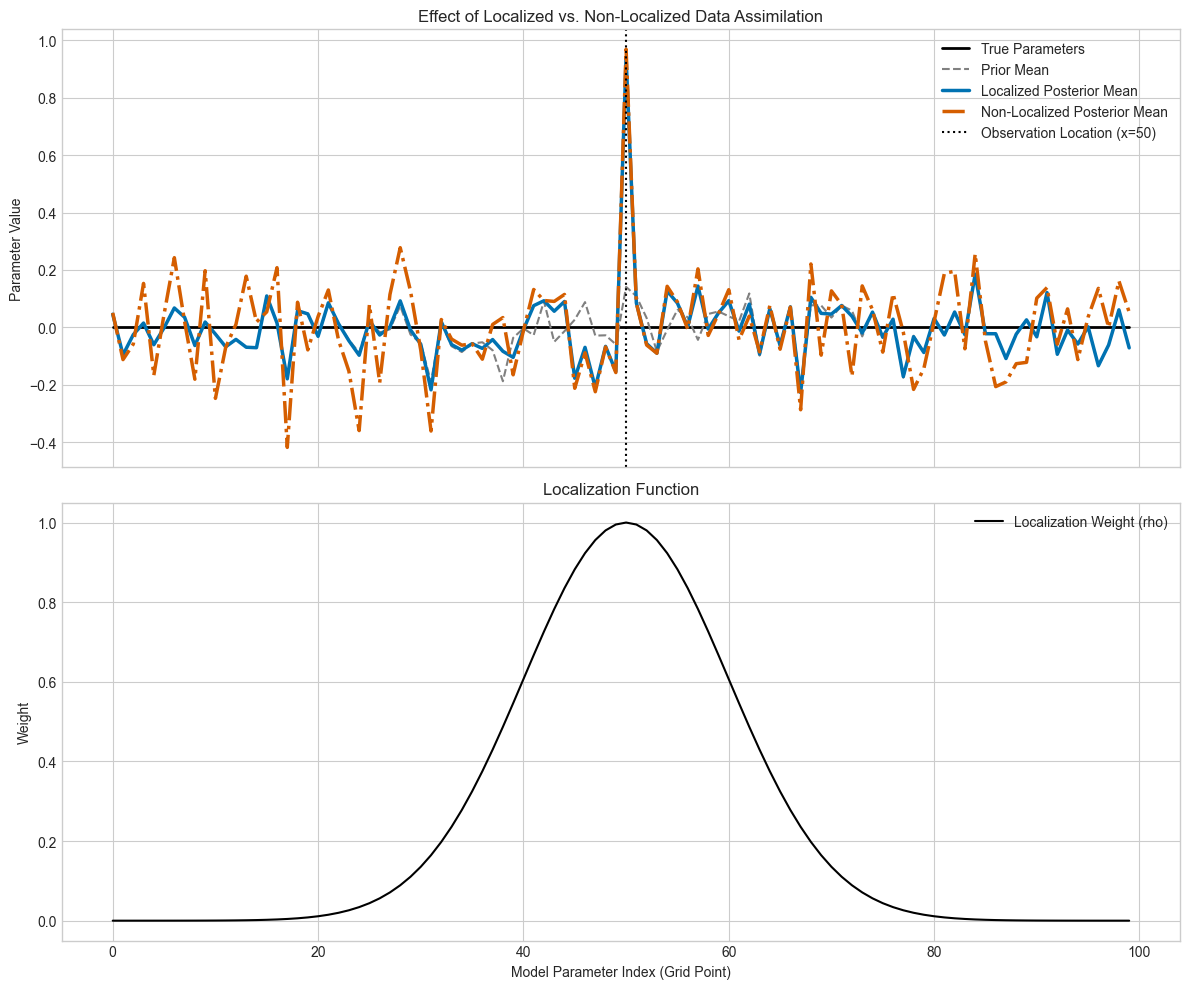

In [12]:
# System properties
N_m = 100  # Number of model parameters (grid points)
N_e = 50   # Ensemble size
j_obs = 50 # Index of the single observation
N_d = 1    # Number of observations

# Assimilation properties
alpha_i = 1 # TODO: Implement multiple iterations
obs_error_var = 0.01 # Variance of observation error
SEED = 42

# Define the "true" model parameters
true_parameters = np.zeros(N_m)

# Define the "true" observation vector (1D)
true_observations = np.array([1.0])

# Observation error covariance `C_D`. Since N_d=1, it's a 1-element vector.
C_D = np.array([obs_error_var])

# --- 2. Generate Initial Ensemble and Predictions ---

# Create initial ensemble of parameters `X` (prior)
# Shape: (N_m, N_e)
rng = np.random.default_rng(SEED)
X_initial = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Predict observations `Y` using the identity model `g(x) = x`
# We only observe the state at `j_obs`.
# Shape: (N_d, N_e) -> (1, 50)
Y = X_initial[[j_obs], :]


# --- 3. Construct Localization, Covariance, and Smoother ---

# Localization matrix `rho`
# Shape: (N_m, N_d) -> (100, 1)
localization_radius = 10.0
model_grid = np.arange(N_m)
distances = np.abs(model_grid - j_obs)
# Using a simple Gaussian decay for rho
rho = np.exp(-0.5 * (distances / localization_radius)**2).reshape(-1, 1)

smoother = DistanceESMDA(
    covariance=C_D,
    observations=true_observations,
    alpha=1,
    seed=SEED
)
smoother_ESMDA = ESMDA(
    covariance=C_D,
    observations=true_observations,
    alpha=1,
    seed=SEED)

D = smoother.perturb_observations(
    ensemble_size=N_e, alpha=alpha_i
)

# --- 4. Run Assimilation and Analyze ---

# Run the assimilation
X_posterior = smoother.assimilate(X=X_initial, Y=Y, rho=rho)
X_posterior_ESMDA = smoother_ESMDA.assimilate(X=X_initial, Y=Y)

# Calculate the mean of the prior and posterior ensembles
prior_mean = np.mean(X_initial, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_ESMDA = np.mean(X_posterior_ESMDA, axis=1)

# --- 5. Plot the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Ensemble means
# Use a colorblind-safe palette and distinct line styles
# From Paul Tol's color schemes: https://personal.sron.nl/~pault/
color_localized = '#0072B2'  # Blue
color_non_localized = '#D55E00' # Orange

ax1.plot(model_grid, true_parameters, color='black', linestyle='-', linewidth=2, label='True Parameters')
ax1.plot(model_grid, prior_mean, color='gray', linestyle='--', linewidth=1.5, label='Prior Mean')
ax1.plot(model_grid, posterior_mean, color=color_localized, linestyle='-', linewidth=2.5, label='Localized Posterior Mean')
ax1.plot(model_grid, posterior_mean_ESMDA, color=color_non_localized, linestyle='-.', linewidth=2.5, label='Non-Localized Posterior Mean')
ax1.axvline(j_obs, color='black', linestyle=':', linewidth=1.5, label=f'Observation Location (x={j_obs})')

ax1.set_ylabel('Parameter Value')
ax1.set_title('Effect of Localized vs. Non-Localized Data Assimilation')
ax1.legend()
ax1.grid(True)

# Plot 2: Localization weights
ax2.plot(model_grid, rho, color='black', label='Localization Weight (rho)')
ax2.set_xlabel('Model Parameter Index (Grid Point)')
ax2.set_ylabel('Weight')
ax2.set_title('Localization Function')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# What to expect:
# The prior mean (gray dashed line) should be a noisy line centered around 0.
#
# The Localized Posterior Mean (red solid line) should be pulled from approx. 0 towards the
# observation value of 1.0. This update should be strong at the observation location (x=50)
# and decay smoothly to zero away from it, following the shape of the localization function.
#
# The Non-Localized Posterior Mean (green dash-dot line) will show updates across the ENTIRE
# domain, not just near the observation. This is because a small ensemble size creates spurious
# correlations between the observation and distant, unrelated parameters.
#
# Consequently, the non-localized update will look noisy and physically unrealistic across the
# domain. This demonstrates why localization is essential to generate plausible reservoir models,
# as applying updates without it can lead to results that differ significantly from the prior models.

# 2D Test

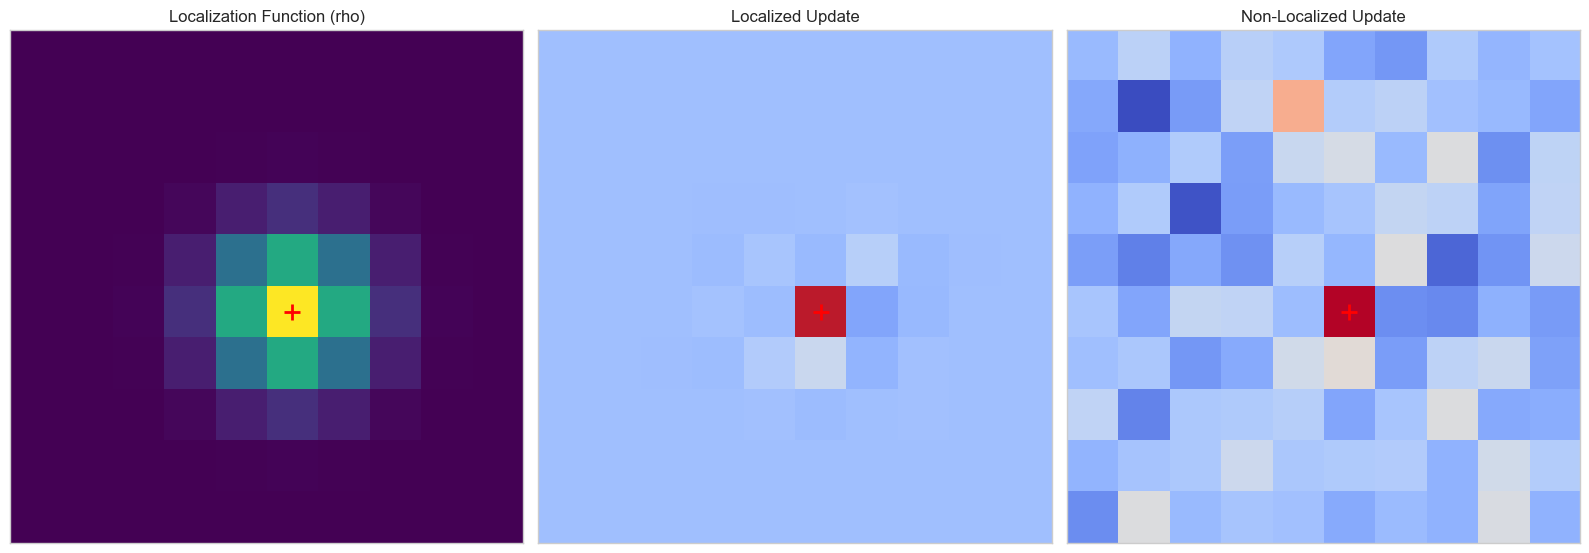

In [13]:
Nx, Ny = 10, 10
N_m = Nx * Ny
N_e = 50
x_obs, y_obs = 5, 5

seed = 42

alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 2D observation index to a flat 1D index for slicing
flat_obs_index = y_obs * Nx + x_obs
Y = X_prior[[flat_obs_index], :]

# --- Construct 2D Localization `rho` ---
localization_radius = 1

# Create a 2D coordinate grid
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
# Calculate 2D Euclidean distance from every point to the observation
distances_2d = np.sqrt((xx - x_obs)**2 + (yy - y_obs)**2)
# Flatten the 2D distance map to a 1D vector to match the parameter vector
distances = distances_2d.flatten()

rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

# --- Run Assimilations ---
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data for Plotting ---
# Reshape the 1D vectors back into 2D grids for visualization
prior_mean = np.mean(X_prior, axis=1)
prior_mean_2d = prior_mean.reshape((Ny, Nx))
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_2d = posterior_mean.reshape((Ny, Nx))

posterior_mean_global = np.mean(X_posterior_global, axis=1)
posterior_mean_global_2d = posterior_mean_global.reshape((Ny, Nx))
rho_2d = rho.reshape((Ny, Nx))

# It's often more insightful to visualize the UPDATE (posterior - prior)
update_localized_2d = posterior_mean_2d - prior_mean_2d
update_global_2d = posterior_mean_global_2d - prior_mean_2d

# --- Create the Plots ---
# Use a 2x3 grid to show the most important comparisons
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

# Find the min/max across both update fields for a fair comparison
update_min = min(update_localized_2d.min(), update_global_2d.min())
update_max = max(update_localized_2d.max(), update_global_2d.max())

# Localization Function (rho)
im = axes[0].imshow(rho_2d, cmap='viridis')
axes[0].set_title('Localization Function (rho)')

# Localized Update
im = axes[1].imshow(update_localized_2d, cmap='coolwarm', vmin=update_min, vmax=update_max)
axes[1].set_title('Localized Update')

# Non-Localized Update
im = axes[2].imshow(update_global_2d, cmap='coolwarm', vmin=update_min, vmax=update_max)
axes[2].set_title('Non-Localized Update')

# Mark the observation location on all plots and hide ticks
for ax in axes.flat:
    ax.plot(x_obs, y_obs, 'r+', markersize=12, markeredgewidth=2) # Red cross
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 3D case

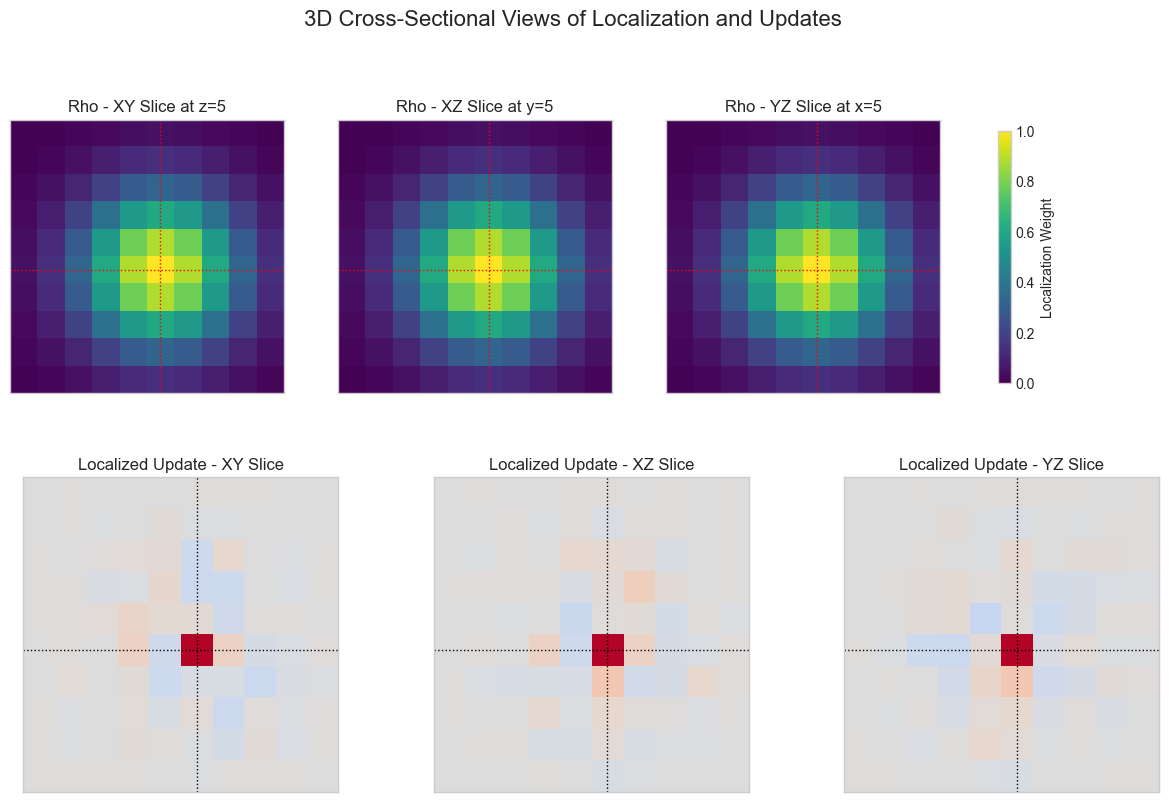

In [14]:
Nx, Ny, Nz = 10, 10, 10
N_m = Nx * Ny * Nz
N_e = 50
x_obs, y_obs, z_obs = 5, 5, 5

seed = 42
alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 3D observation index to a flat 1D index for slicing
flat_obs_index = (z_obs * Nx * Ny) + (y_obs * Nx) + x_obs
Y = X_prior[[flat_obs_index], :]

# --- Construct 3D Localization `rho` ---
localization_radius = 2.0

# Create 3D coordinate grids
zz, yy, xx = np.meshgrid(np.arange(Nz), np.arange(Ny), np.arange(Nx), indexing='ij')
# Calculate 3D Euclidean distance from every point to the observation
distances_3d = np.sqrt((xx - x_obs)**2 + (yy - y_obs)**2 + (zz - z_obs)**2)
distances = distances_3d.flatten()

rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

# --- Run Assimilations ---
# This part remains the same as the assimilation logic is dimension-agnostic
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data and Prepare for 3D Visualization ---
prior_mean = np.mean(X_prior, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)

# Reshape the 1D vectors into 3D volumes
rho_3d = rho.reshape((Nz, Ny, Nx))
update_localized_3d = (posterior_mean - prior_mean).reshape((Nz, Ny, Nx))
update_global_3d = (np.mean(X_posterior_global, axis=1) - prior_mean).reshape((Nz, Ny, Nx))

# --- Create 3D Cross-Sectional Plots ---
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('3D Cross-Sectional Views of Localization and Updates', fontsize=16)

# --- Row 1: Slices of the Localization Function (rho) ---
im_rho = axes[0, 0].imshow(rho_3d[z_obs, :, :], cmap='viridis', vmin=0, vmax=1)
axes[0, 0].set_title(f'Rho - XY Slice at z={z_obs}')

axes[0, 1].imshow(rho_3d[:, y_obs, :], cmap='viridis', vmin=0, vmax=1)
axes[0, 1].set_title(f'Rho - XZ Slice at y={y_obs}')

axes[0, 2].imshow(rho_3d[:, :, x_obs], cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title(f'Rho - YZ Slice at x={x_obs}')

fig.colorbar(im_rho, ax=axes[0, :], location='right', shrink=0.8, label='Localization Weight')

# --- Slices of the Update Fields ---
# Find a single, symmetric color scale for both update plots
update_max_abs = np.max([np.abs(update_localized_3d), np.abs(update_global_3d)])
vmin_update, vmax_update = -update_max_abs, update_max_abs

# Localized Update
im_update = axes[1, 0].imshow(update_localized_3d[z_obs, :, :], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 0].set_title(f'Localized Update - XY Slice')

axes[1, 1].imshow(update_localized_3d[:, y_obs, :], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 1].set_title(f'Localized Update - XZ Slice')

axes[1, 2].imshow(update_localized_3d[:, :, x_obs], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 2].set_title(f'Localized Update - YZ Slice')

# --- Add Annotations to All Plots ---
# Add crosshairs to pinpoint the observation location in each slice
axes[0, 0].axhline(y_obs, color='r', linestyle=':', lw=1); axes[0, 0].axvline(x_obs, color='r', linestyle=':', lw=1)
axes[0, 1].axhline(z_obs, color='r', linestyle=':', lw=1); axes[0, 1].axvline(x_obs, color='r', linestyle=':', lw=1)
axes[0, 2].axhline(z_obs, color='r', linestyle=':', lw=1); axes[0, 2].axvline(y_obs, color='r', linestyle=':', lw=1)

axes[1, 0].axhline(y_obs, color='k', linestyle=':', lw=1); axes[1, 0].axvline(x_obs, color='k', linestyle=':', lw=1)
axes[1, 1].axhline(z_obs, color='k', linestyle=':', lw=1); axes[1, 1].axvline(x_obs, color='k', linestyle=':', lw=1)
axes[1, 2].axhline(z_obs, color='k', linestyle=':', lw=1); axes[1, 2].axvline(y_obs, color='k', linestyle=':', lw=1)

# Hide axis ticks for a cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Performance

Starting large-scale performance test...
This may take several minutes...
Testing large-scale performance...

Test Case 1: N_params=1,000,000, N_wells=10, Obs_per_well=100, Total_obs=1000
Grid: 1000x1000, Wells: 10, Obs/well: 100
  Trial 1/1...
    Generating ensemble...
    Selecting well locations and observations...
    Creating localization matrix...
    Running assimilation...
    Time: 13.49s
    Creating visualization...


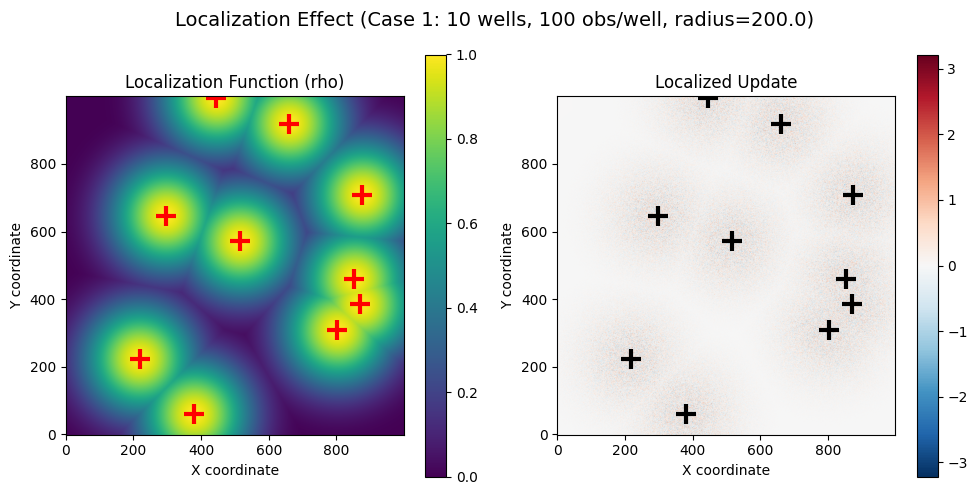

    Localization statistics:
      Sparsity: 0.3% of parameters have zero localization
      Max localization: 1.000
      Update range: [-3.2205, 2.7563]
      Update std: 0.3559
      Rho shape: (1000000, 1000)
  Average time: 13.49 ± 0.00s
  Time per parameter: 13.49 μs/param
  Time per well: 1349.00 ms/well
  Time per observation: 13.49 ms/obs
Function time_large_scale_performance:
  Total time: 15.33s

LARGE-SCALE PERFORMANCE ANALYSIS

Case 1: 1,000,000 params, 10 wells, 100 obs/well
  Total obs: 1000
  Total time: 13.49 ± 0.00 seconds
  Throughput: 74129 params/second
  Time per param: 13.49 μs
  Time per well: 1349.00 ms
  Time per obs: 13.49 ms


In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt

def gaspari_cohn_localization(distances, radius):
    """Gaspari-Cohn localization with compact support at 2*radius"""
    r = distances / radius
    rho = np.zeros_like(r)
    
    # Compact support: zero beyond 2*radius
    mask1 = r <= 1
    mask2 = (r > 1) & (r <= 2)
    
    # Gaspari-Cohn function with smooth derivatives
    rho[mask1] = 1 - (5/3)*r[mask1]**2 + (5/8)*r[mask1]**3 + (1/2)*r[mask1]**4 - (1/4)*r[mask1]**5
    rho[mask2] = 4 - 5*r[mask2] + (5/3)*r[mask2]**2 + (5/8)*r[mask2]**3 - (1/2)*r[mask2]**4 + (1/12)*r[mask2]**5 - 2/(3*r[mask2])
    
    return rho

def create_multi_well_localization(well_locations, obs_per_well, grid_size, radius):
    """Create localization matrix where all observations at same well share localization
    
    Parameters:
    -----------
    well_locations : array_like
        Indices of well locations
    obs_per_well : int
        Number of observations per well
    grid_size : int
        Size of square grid (grid_size x grid_size)
    radius : float
        Localization radius (function has compact support at 2*radius)
    
    Returns:
    --------
    rho : ndarray
        Localization matrix of shape (n_params, n_obs)
    """
    
    # Calculate problem dimensions
    n_wells = len(well_locations)
    n_obs = n_wells * obs_per_well  # Total observations across all wells
    n_params = grid_size * grid_size  # Total grid parameters
    
    # Step 1: Create 2D coordinate grids for the entire spatial domain
    # xx[i,j] = j coordinate, yy[i,j] = i coordinate for grid point (i,j)
    xx, yy = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    
    # Step 2: Find the minimum distance from each grid point to ANY well
    # Initialize with infinity - will be replaced with actual distances
    min_distances = np.full((grid_size, grid_size), np.inf)
    
    # Loop through each well location
    for well_idx in well_locations:
        # Convert 1D grid index to 2D coordinates
        # For a 1D index in row-major order: x = index % grid_size, y = index // grid_size
        well_x = well_idx % grid_size      # Column coordinate (0 to grid_size-1)
        well_y = well_idx // grid_size     # Row coordinate (0 to grid_size-1)
        
        # Calculate Euclidean distance from this well to every grid point
        # distances[i,j] = distance from grid point (i,j) to current well
        distances = np.sqrt((xx - well_x)**2 + (yy - well_y)**2)
        
        # Keep the minimum distance to any well for each grid point
        # This creates a "union" of all well influence zones
        # When a parameter is influenced by multiple wells,
        # it gets localized based on the closest well,
        # which ensures strong localization in all well 
        # neighborhoods while being computationally efficient.
        min_distances = np.minimum(min_distances, distances)
    
    # Step 3: Create the base localization pattern using Gaspari-Cohn function
    # This gives a single localization pattern that covers all wells
    # Values are 1.0 near wells, smoothly decrease to 0.0 at distance 2*radius
    rho_base = gaspari_cohn_localization(min_distances, radius).flatten()
    
    # Step 4: Replicate the base pattern for all observations
    # Since all observations at the same well share the same localization,
    # we just repeat the same pattern n_obs times
    # rho[param_i, obs_j] = localization weight for parameter i and observation j
    # 
    # np.tile replicates rho_base column-wise:
    # - rho_base.reshape(-1, 1) makes it a column vector (n_params × 1)
    # - (1, n_obs) tiles it 1 time vertically, n_obs times horizontally
    # Result: (n_params × n_obs) matrix where each column is identical
    rho = np.tile(rho_base.reshape(-1, 1), (1, n_obs))
    
    return rho

def visualize_localization_effect(X_prior, X_posterior, well_locations, rho, grid_size, case_name=""):
    """Visualize the localization function and its effect on the update"""
    
    # Calculate ensemble means
    prior_mean = np.mean(X_prior, axis=1)
    posterior_mean = np.mean(X_posterior, axis=1)
    
    # Reshape to 2D grids
    prior_mean_2d = prior_mean.reshape((grid_size, grid_size))
    posterior_mean_2d = posterior_mean.reshape((grid_size, grid_size))
    rho_2d = rho[:, 0].reshape((grid_size, grid_size))  # Use first column since all are the same
    
    # Calculate update
    update_2d = posterior_mean_2d - prior_mean_2d
    
    # Convert well locations to 2D coordinates
    well_coords = [(idx % grid_size, idx // grid_size) for idx in well_locations]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot 1: Localization function
    im1 = axes[0].imshow(rho_2d, cmap='viridis', origin='lower')
    axes[0].set_title('Localization Function (rho)')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    plt.colorbar(im1, ax=axes[0])
    
    # Mark well locations
    for well_x, well_y in well_coords:
        axes[0].plot(well_x, well_y, 'r+', markersize=15, markeredgewidth=3)
    
    # Plot 2: Localized update
    update_max = max(abs(update_2d.min()), abs(update_2d.max()))
    im2 = axes[1].imshow(update_2d, cmap='RdBu_r', origin='lower', 
                         vmin=-update_max, vmax=update_max)
    axes[1].set_title('Localized Update')
    axes[1].set_xlabel('X coordinate')
    axes[1].set_ylabel('Y coordinate')
    plt.colorbar(im2, ax=axes[1])
    
    # Mark well locations
    for well_x, well_y in well_coords:
        axes[1].plot(well_x, well_y, 'k+', markersize=15, markeredgewidth=3)
    
    plt.suptitle(f'Localization Effect {case_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"    Localization statistics:")
    print(f"      Sparsity: {np.mean(rho_2d == 0) * 100:.1f}% of parameters have zero localization")
    print(f"      Max localization: {rho_2d.max():.3f}")
    print(f"      Update range: [{update_2d.min():.4f}, {update_2d.max():.4f}]")
    print(f"      Update std: {update_2d.std():.4f}")
    print(f"      Rho shape: {rho.shape}")

def time_large_scale_performance():
    """Test performance on large-scale problems"""
    
    # Test cases: (n_params, n_wells, obs_per_well)
    test_cases = [
        (1000*1000, 10, 100),
        #(100*100, 5, 1000),   # 100x100 grid, 5 wells, 1000 obs per well
        #(1000*1000, 50, 20), # 1000x1000 grid, 50 wells, 20 obs per well
        #(1000*1000, 100, 10), # 1000x1000 grid, 100 wells, 10 obs per well
    ]
    
    n_ensemble = 50
    n_trials = 1  # Might want to reduce this for very large problems
    localization_radius = 200.0
    
    results = []
    
    print("Testing large-scale performance...")
    print("=" * 50)
    
    for i, (n_params, n_wells, obs_per_well) in enumerate(test_cases):
        n_obs = n_wells * obs_per_well
        print(f"\nTest Case {i+1}: N_params={n_params:,}, N_wells={n_wells}, Obs_per_well={obs_per_well}, Total_obs={n_obs}")
        
        grid_size = int(np.sqrt(n_params))
        print(f"Grid: {grid_size}x{grid_size}, Wells: {n_wells}, Obs/well: {obs_per_well}")
        
        # Verify it's a perfect square
        assert grid_size * grid_size == n_params, f"Not a perfect square: {n_params}"
        
        trial_times = []
        
        for trial in range(n_trials):
            print(f"  Trial {trial + 1}/{n_trials}...")
            
            # Setup
            #rng = np.random.default_rng(42 + trial)
            rng = np.random.default_rng()
            
            # Generate ensemble
            print("    Generating ensemble...")
            X_prior = rng.normal(0, 0.5, size=(n_params, n_ensemble))
            
            # Generate well locations and observations
            print("    Selecting well locations and observations...")
            
            # First, select well locations (unique spatial positions)
            well_locations = rng.choice(n_params, size=n_wells, replace=False)
            
            # Then, create multiple observations per well
            # For simplicity, all observations at a well have the same location
            obs_indices = []
            for well_loc in well_locations:
                for _ in range(obs_per_well):
                    obs_indices.append(well_loc)
            
            obs_indices = np.array(obs_indices)
            Y = X_prior[obs_indices, :]
            
            # Start timing the critical section
            start_time = time.perf_counter()
            
            print("    Creating localization matrix...")
            
            # Create localization matrix based on well locations
            # All observations at same well share same localization
            rho = create_multi_well_localization(
                well_locations, obs_per_well, grid_size, localization_radius
            )

            assert rho.shape == (n_params, n_wells * obs_per_well)
            
            print("    Running assimilation...")
            
            # Run assimilation with all observations
            esmda = DistanceESMDA(
                covariance=np.eye(n_obs) * 0.01,
                observations=np.ones(n_obs),
                alpha=1,
                seed=rng
            )

            X_posterior = esmda.assimilate(X=X_prior, Y=Y, rho=rho)
            
            end_time = time.perf_counter()
            
            total_time = end_time - start_time
            trial_times.append(total_time)
            
            print(f"    Time: {total_time:.2f}s")
            
            # Visualize the localization effect
            print("    Creating visualization...")
            visualize_localization_effect(
                X_prior, X_posterior, well_locations, rho, grid_size, 
                case_name=f"(Case {i+1}: {n_wells} wells, {obs_per_well} obs/well, radius={localization_radius})"
            )
            
            # Clean up large arrays to free memory
            del X_prior, X_posterior, Y, rho
        
        avg_time = np.mean(trial_times)
        std_time = np.std(trial_times)
        
        result = {
            'n_params': n_params,
            'n_wells': n_wells,
            'obs_per_well': obs_per_well,
            'n_obs': n_obs,
            'avg_time': avg_time,
            'std_time': std_time,
            'trial_times': trial_times
        }
        results.append(result)
        
        print(f"  Average time: {avg_time:.2f} ± {std_time:.2f}s")
        print(f"  Time per parameter: {avg_time/n_params*1e6:.2f} μs/param")
        print(f"  Time per well: {avg_time/n_wells*1e3:.2f} ms/well")
        print(f"  Time per observation: {avg_time/n_obs*1e3:.2f} ms/obs")
    
    return results

def analyze_large_scale_results(results):
    """Analyze and visualize large-scale results"""
    
    print("\n" + "=" * 60)
    print("LARGE-SCALE PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    for i, result in enumerate(results):
        print(f"\nCase {i+1}: {result['n_params']:,} params, {result['n_wells']} wells, {result['obs_per_well']} obs/well")
        print(f"  Total obs: {result['n_obs']}")
        print(f"  Total time: {result['avg_time']:.2f} ± {result['std_time']:.2f} seconds")
        print(f"  Throughput: {result['n_params']/result['avg_time']:.0f} params/second")
        print(f"  Time per param: {result['avg_time']/result['n_params']*1e6:.2f} μs")
        print(f"  Time per well: {result['avg_time']/result['n_wells']*1e3:.2f} ms")
        print(f"  Time per obs: {result['avg_time']/result['n_obs']*1e3:.2f} ms")

# Performance monitoring decorator (simplified)
def monitor_performance(func):
    """Decorator to monitor time only"""
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        
        result = func(*args, **kwargs)
        
        end_time = time.perf_counter()
        
        print(f"Function {func.__name__}:")
        print(f"  Total time: {end_time - start_time:.2f}s")
        
        return result
    return wrapper

# Modified main execution
if __name__ == "__main__":
    time_large_scale_performance = monitor_performance(time_large_scale_performance)
    
    print("Starting large-scale performance test...")
    print("This may take several minutes...")
    
    results = time_large_scale_performance()
    analyze_large_scale_results(results)